<a href="https://colab.research.google.com/github/kundana12345/DataScience/blob/main/KundAddalaU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 4 Project: Using Hierarchies to Account for Dependence Between Groups



Introduction



I will be using hierarchical models to measure the returns of different national stock markets, such as SP 500 and and Istambul Stock Exchange.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import graphviz as gv
import pymc as pm


Data

The data is from https://archive.ics.uci.edu/dataset/247/istanbul+stock+exchange, it has the returns from the Istambul Stock Exchange along with others: SP, DAX, FTSE, NIKKEI, BOVESPA, MSCE_EU, MSCI_EM from Jun 5, 2009 to Feb 22, 2011. This source got its data from imkb.gov.tr and finance.yahoo.com.

In [3]:
path_data = '/content/drive/My Drive/Data Science/International Stock Exchange Data3.csv'

In [37]:
data = pd.read_csv(path_data)

In [38]:
data

,date,ISE,ISEUSD,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,9-Jan-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802
...,...,...,...,...,...,...,...,...,...,...
531,16-Feb-11,0.008599,0.013400,0.006238,0.001925,0.007952,0.005717,0.018371,0.006975,0.003039
532,17-Feb-11,0.009310,0.015977,0.003071,-0.001186,0.000345,0.002620,0.001686,-0.000581,0.001039
533,18-Feb-11,0.000191,-0.001653,0.001923,0.002872,-0.000723,0.000568,0.005628,0.000572,0.006938
534,21-Feb-11,-0.013069,-0.013706,-0.020742,-0.014239,-0.011275,0.001358,-0.011942,-0.012615,-0.000958


This was me getting the data to look more like the Unit 4 Answer Key:

In [45]:
#from ChatGPT
date_col = [col for col in data.columns if str(col).strip().lower() == "date"]
if len(date_col) == 0:
    raise ValueError("No 'date' column found in DataFrame after fixing headers.")
else:
    date_col = date_col[0]

# --- Step 3: Convert from wide to long format ---
data_long = data.melt(
    id_vars=[date_col],
    var_name="StockMarket",
    value_name="Return"
)

# --- Step 4: Rename date column and format consistently ---
data_long = data_long.rename(columns={date_col: "Date"})

# Explicitly parse dates in day-month-year format (e.g., 5-Jan-09)
data_long["Date"] = pd.to_datetime(
    data_long["Date"],
    format="%d-%b-%y",
    errors="coerce"
).dt.strftime("%m/%d/%Y")

# --- Step 5: Reorder columns ---
data_long = data_long[["Date", "StockMarket", "Return"]]

In [46]:
data_long

,Date,StockMarket,Return
0,01/05/2009,ISE,0.035754
1,01/06/2009,ISE,0.025426
2,01/07/2009,ISE,-0.028862
3,01/08/2009,ISE,-0.062208
4,01/09/2009,ISE,0.009860
...,...,...,...
4819,02/16/2011,EM,0.003039
4820,02/17/2011,EM,0.001039
4821,02/18/2011,EM,0.006938
4822,02/21/2011,EM,-0.000958


(array([3.000e+00, 2.300e+01, 1.320e+02, 6.630e+02, 2.727e+03, 1.072e+03,
        1.670e+02, 3.100e+01, 5.000e+00, 1.000e+00]),
 array([-0.0847159 , -0.06618224, -0.04764858, -0.02911492, -0.01058126,
         0.0079524 ,  0.02648606,  0.04501972,  0.06355337,  0.08208703,
         0.10062069]),
 <BarContainer object of 10 artists>)

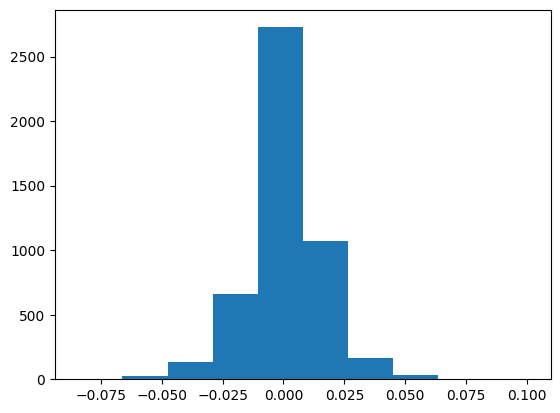

In [50]:
plt.hist(data_long['Return'])

In [53]:
print(data_long['Return'].mean())
print(data_long['Return'].median())

0.0008561156409618575
0.000787776


This is the histogram of the column we care about: Return. This shows it is centered around 0. There is a very small variance. There is little skew (but if anything it is slightly right). There is higher kurtosis, because it has heavier tails.

This helps us find all the different stock markets we are comparing.

In [48]:
stock_encode = pd.Categorical(data_long['StockMarket'])

In [49]:
stock_encode

['ISE', 'ISE', 'ISE', 'ISE', 'ISE', ..., 'EM', 'EM', 'EM', 'EM', 'EM']
Length: 4824
Categories (9, object): ['BOVESPA', 'DAX', 'EM', 'EU', ..., 'ISE', 'ISEUSD', 'NIKKEI', 'SP']

In [51]:
stock_idx = stock_encode.codes
stock_idx

array([5, 5, 5, ..., 2, 2, 2], dtype=int8)

In [54]:
stock_coords = {"Return": stock_encode.categories}
stock_coords

{'Return': Index(['BOVESPA', 'DAX', 'EM', 'EU', 'FTSE', 'ISE', 'ISEUSD', 'NIKKEI', 'SP'], dtype='object')}

Non-hierarchical

This is us assuming that knowing something about one stock market doesn't help us know something about another stock market.

In [ ]:
with pm.Model(coords=stock_coords) as stock_nh_model:
    #priors

    μ = pm.Normal('μ', mu=0, sigma=1,
                  dims="Return")
    σ = pm.HalfNormal('σ', sigma=1,
                      dims="Return")

    #posterior
    y = pm.Normal('y',
                  mu = μ[stock_idx],
                  sigma = σ[stock_idx],
                  observed=data_long.Return)

    idata_stock_nh = pm.sample()

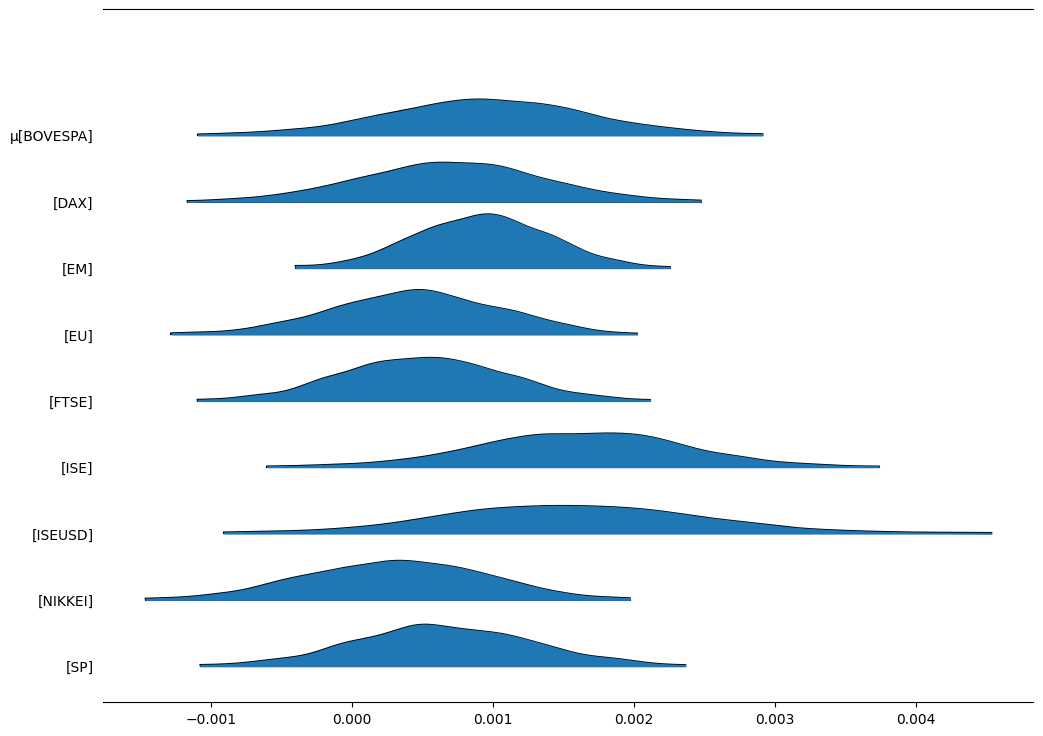

In [56]:
axes = az.plot_forest(idata_stock_nh, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

It looks like the means are pretty different, but look at the range of the graph, it is from -0.001 to 0.004, that is quite small. Their means seem to all be very close to 0, all slightly above 0.

Output()

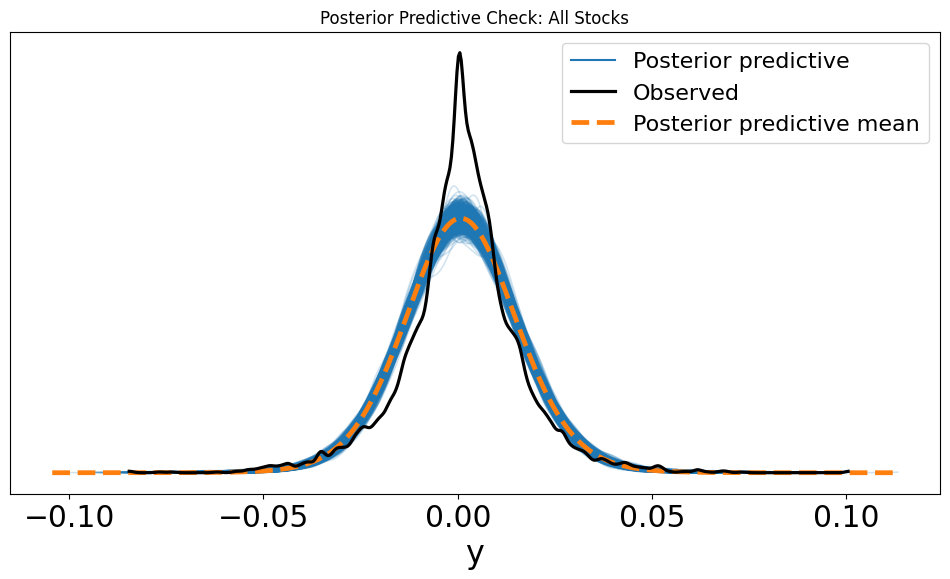

In [58]:
#from ChatGPT
with stock_nh_model:
    ppc_stock = pm.sample_posterior_predictive(idata_stock_nh, var_names=['y'])

az.plot_ppc(ppc_stock, figsize=(12,6))
plt.title("Posterior Predictive Check: All Stocks")
plt.show()


The model worked pretty well except for in the middle at 0, it underestimated the amount of returns that were close to 0.

Hierarchical Model

In [ ]:
with pm.Model(coords=stock_coords) as stock_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 0.1)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 0.1)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu, # I include the hyperprior in my prior
                  sigma = μ_sd, # I include the hyperprior in my prior
                  dims = "Return")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "Return")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[stock_idx], #I include the prior in my likelihood
                  sigma = σ[stock_idx], #I include the prior in my likelihood
                  observed = data_long.Return)

    #cs for chemshift, h for heirarchical
    idata_stock_h = pm.sample()

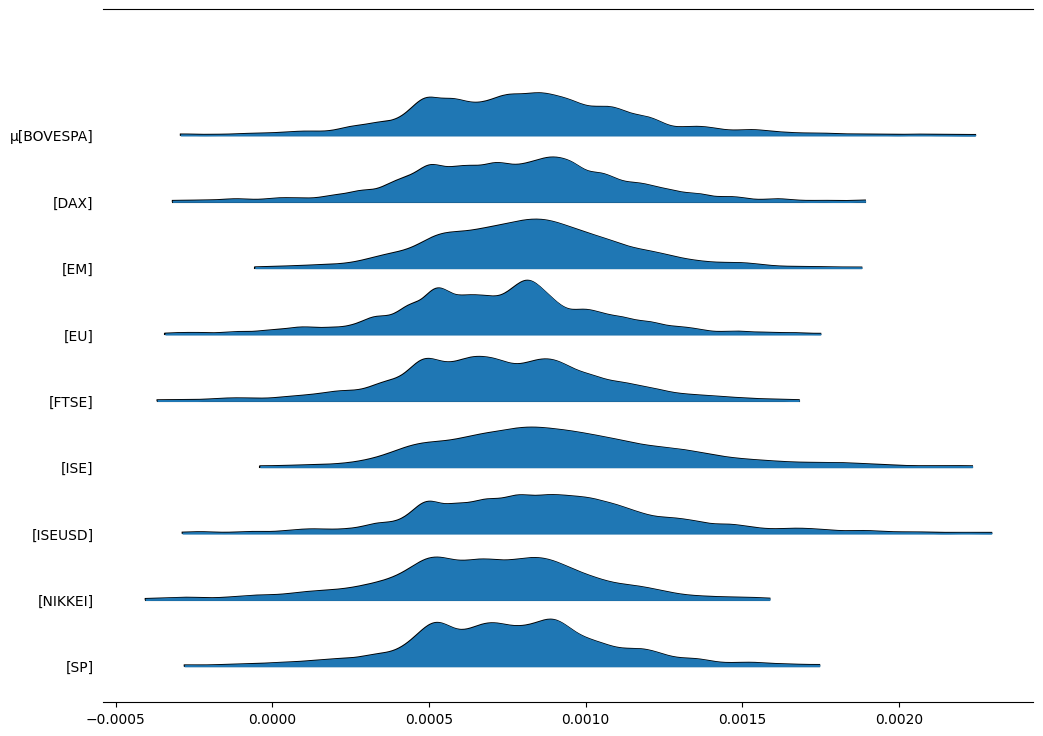

In [66]:
axes = az.plot_forest(idata_stock_h, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

Output()

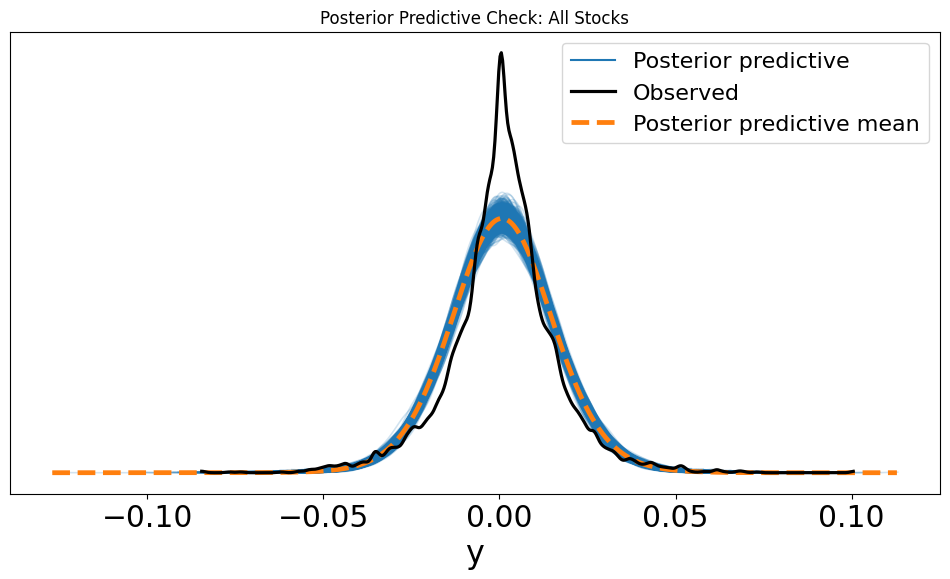

In [69]:
with stock_nh_model:
    ppc_stock = pm.sample_posterior_predictive(idata_stock_nh, var_names=['y'])

az.plot_ppc(ppc_stock, figsize=(12,6))
plt.title("Posterior Predictive Check: All Stocks")
plt.show()

The hierarchical models have less variation (note: look at the numbers on the x-axis, it looks like hierarchical is more spread out, but the numbers are less different). This means that the model thinks that the different stock markets do have similar returns.

Conclusion

We can see that all of these markets seem to be increasing more than they decrease, all by pretty similar amounts. BUT, it is very important to note how small these increases are and within these small increases there is still so much variance between what the positive returns can be for each stock market. The mean seems to be around 0.00055.

When looking at the differences between the stock markets, we can see most of them seem to be symmetrical: EU, NIKKEI, for example. However, there are some that seem to be slightly left or right skew, indicating more variance in either higher or lower returns. For example, ISE seems to have more variance for its more higher returns.